## Loads mouse tracking data, plots it and annotates social interactions

- A notebook for exploring the data and project structure.
- Also enables choosing appropriate annotation values.
- Inspiration mainly taken from the notebooks: "00-identify-neurons" and "ratemap" from this project.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('../ca2-mec')
import data_processing as dp
import matplotlib.pyplot as plt

import exdir
%matplotlib inline

In [4]:
project_path = dp.project_path()
#project_path = '../../CA2prosjektmappe'
project = expipe.get_project(project_path)
actions = project.actions

In [17]:
# choose an action
action_id = '002-121220-1'#'133-100720-7'
action = actions[action_id]
print(action.attributes)
print(action.id, action.type)

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.01
smoothing = 0.05
baseline_duration = None # 600

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=True, baseline_duration=baseline_duration,
)

# common values for all units == faster calculations
x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])

{'registered': '2020-12-14T14:33:03', 'datetime': '2020-12-12T11:58:24', 'type': 'Recording', 'tags': ['open-ephys'], 'entities': ['002'], 'users': ['sarah'], 'location': 'ibv', 'data': {'main': 'actions\\002-121220-1\\data\\main.exdir'}}
002-121220-1 Recording


In [18]:
"""
Process positional data in the following ways:
1. Change origo from top left to bottom left
2. Assume rat has travelled to all box borders. Thus, box size should be max/min of positional data from rat.
"""
# Set origo from top left corner to bottom left corner.
y = 1 - y
print(np.min(x), 1-np.max(x))

# Reset box borders
x -= np.min(x)
x /= np.max(x)

y -= np.min(y)
y /= np.max(y)

0.09481976749898105 0.10878132013719666


In [19]:
# Creates a meshgrid of the box
xx,yy = np.meshgrid(*data_loader.spatial_bins)
zz = np.zeros(xx.shape)

idxs_x = (np.around(x, decimals=2) * (xx.shape[1]-1)).astype(int)
idxs_y = (np.around(y, decimals=2) * (xx.shape[0]-1)).astype(int)

# populate places the mouse has been, ignoring temporal information
# zz[idxs_y, idxs_x] = 1

# populate places the mouse has been, where recent places have the strongest color
zz[idxs_y, idxs_x] = (t / np.max(t) + 1) / 2

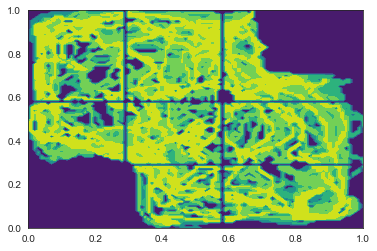

In [20]:
plt.rcParams['image.cmap'] = 'viridis'
plt.contourf(xx,yy,zz)
plt.show()
plt.close()

(y0,x0) = (70,70)
(y1,x1) = (30,32)


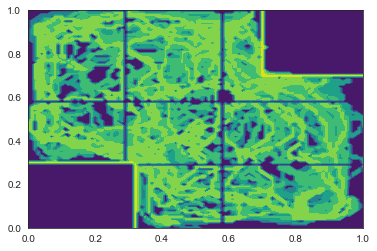

In [22]:
"""
Semi-manual SELECTION of the coordinates of the two transparent mouse-boxes
"""
tr_x,tr_y,bl_x,bl_y=0.8, 0.8, 0.2, 0.2

# top right rat box borders
y0 = np.max(y[np.where(x > tr_x)])
x0 = np.max(x[np.where(y > tr_y)])

# bottom left mouse box borders
y1 = np.min(y[np.where(x < bl_x)])
x1 = np.min(x[np.where(y < bl_y)])

# Cast to nearest (rounded) meshgrid coordinates
tmp = np.array([y0,x0,y1,x1])*(xx.shape[0]-1)
tmp = tmp.astype(int)
r_y0,r_x0,r_y1,r_x1 = tmp
print("(y0,x0) = ({},{})".format(r_y0,r_x0))
print("(y1,x1) = ({},{})".format(r_y1,r_x1))

# -- draw the implicit lines defined by the annotated corner point of the transparent boxes --
#zz_copy = zz.copy()
color_strength = 1.1
# top right
zz[r_y0,r_x0:] = color_strength
zz[r_y0:,r_x0] = color_strength

# bottom left
zz[r_y1,:r_x1] = color_strength
zz[:r_y1,r_x1] = color_strength

plt.contourf(xx,yy,zz)
plt.show()
plt.close()

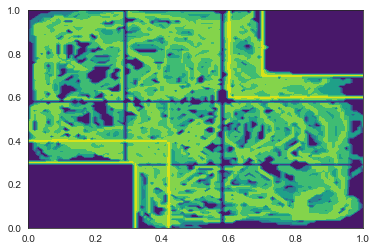

In [23]:
"""
Semi-manual CREATION of SOCIAL ZONE wrt. box size (0-1) and annotated transparent box border locations (y0,x0,y1,x1)
"""

# Manual selection of margins for transparent boxes in each direction
m_y0,m_x0,m_y1,m_x1 = 0.1, 0.1, 0.1, 0.1

# Create social zone boundaries
s_y0,s_x0,s_y1,s_x1 = y0-m_y0,x0-m_x0,y1+m_y1,x1+m_x1

# Cast to nearest (rounded) meshgrid coordinates
tmp = np.array([s_y0,s_x0,s_y1,s_x1])*(xx.shape[0]-1)
tmp = tmp.astype(int)
r_y0,r_x0,r_y1,r_x1 = tmp

# -- draw the implicit lines defined by social zone boundaries --
#zz = zz_copy.copy()
color_strength = 1.1
# top right
zz[r_y0,r_x0:] = color_strength
zz[r_y0:,r_x0] = color_strength

# bottom left
zz[r_y1,:r_x1] = color_strength
zz[:r_y1,r_x1] = color_strength

plt.contourf(xx,yy,zz)
plt.show()

In [24]:
"""
Find which indecies in x,y the animal is socializing
"""
print("Social boundaries: ", s_y0,s_x0,s_y1,s_x1)

# top right social indecies 
mask = x > s_x0
mask *= (y > s_y0)
# bottom left social indecies
mask2 = x < s_x1
mask2 *= (y < s_y1)

mask += mask2

Social boundaries:  0.6027742699091039 0.6067034850818445 0.4007883502804662 0.4290702294702109


In [25]:
"""
Extract the x,y locations where the animal is socializing
"""
social_x = x[mask]
social_y = y[mask]
print(social_x.shape, social_y.shape)

(29698,) (29698,)


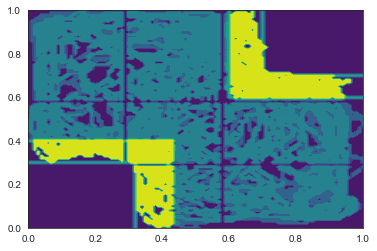

In [26]:
idxs_x = np.around(social_x, decimals=2) * (xx.shape[0]-1)
idxs_x = idxs_x.astype(int)

idxs_y = np.around(social_y, decimals=2) * (xx.shape[0]-1)
idxs_y = idxs_y.astype(int)

zz[idxs_y, idxs_x] = 2
plt.contourf(xx,yy,zz)
plt.show()